# Advanced Primary Flare Detection

We covered the basics of using flare_finder to detect flares in TESS ligthcurves. In the end we saw a lightcurve labeling flares in red and blue. Here we'll be focusing on those red flares, the primary flares. TOFFEE contains a lot of dials to turn affecting primary flare detection we'll explore to show how they can be used for your specific science goals.

In [3]:
import toffee
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

# Prepare a lightcurve

We'll bring back the synthetic lightcurve from the last tutorial with some minor alterations to focus on the main tools of the trade in terms of primary flare detection:

**magic_flare_std**: a float variable that controls how big a flare needs to be to register as a detection. magic_flare_std is the scalar multiple to the global spread, σ, to dictate how bright a series of points must be for classification as a flare.

**consecutive**: a boolean variable controlling whether the points in the flare need to be strictly consecutive

**prim_marg_rate**: a float variable controlling how TOFFEE defines the start and end of a flare based on the flux of points surrounding a bright epoch measured relative to magic_flare_std

**rate_above_threshold** = Only matters if consecutive == False. Float variable controlling how many points need to be above the flux threshold set by magic_flare_std for the epoch to be considered bright enough. Default value is 0.75 for the "three in four" rule. Recommended to never go lower than 0.7

One thing we'll quickly notice is that these variables really only affect detection of small amp flares. The high amp flares will always be found because it's always so easy. However the statistical majority of the flares are low amp so it's worth knowing these variables. 

The default values of these are oriented around the specific science goals of Pratt et al 2025 which needed a pure sample of flares that had high confidence of being flares. Moderate incompleteness was acceptable to prevent bias towards the measured results. For your goals make sure to tweak this to your desires.

NOTE:

One other detail that won't be deeply explored here is flag_values

flag_values: array-like varible containing the values of quality that we will consider for analysis. Recommended values are [0] or [0, 512]

Occasionally the peaks of a flare can be labeled with quality flag 512 for sudden increases in flux. In Pratt et al. 2025 we do not consider these points and only use quality flags of 0 but if you want to include these values you can using TOFFEE.

In [5]:
#decay
def dbl_exp_decay(x, start_time, alpha_0, beta_0, alpha_1, beta_1, C):
    return (alpha_0 * np.exp(- beta_0 * (x - start_time)) +
            alpha_1 * np.exp(- beta_1 * (x - start_time))  + C)

def generate_synth_lightcurve():

    np.random.seed(42)
    
    #Simple, detrended lightcurve
    time = np.linspace(10, 30, 10000) #just some time labels for TOFFEE
    flux = 1 + np.random.normal(0, 2.5*10**-3, 10000) #Note we set the spread of the points to 10**-2
    flux_err = np.full(10000, 10**-2) #same as spread of points
    quality = np.full(10000, 0) #state all qualities are good
    
    #Add a small flare
    flux[1000:1020] = dbl_exp_decay(time[1000:1020], time[1000], 0.0075, 50, 0.0075, 100, 1) + np.random.normal(0, 2.5*10**-3, 20)
    
    #Add a medium flare
    flux[2000:2050] = dbl_exp_decay(time[2000:2050], time[2000], 0.02, 150, 0.02, 200, 1) + np.random.normal(0, 2.5*10**-3, 50)
    
    #Add a large flare
    flux[4000:4100] = dbl_exp_decay(time[4000:4100], time[4000], 0.5, 200, 0.5, 300, 1) + np.random.normal(0, 2.5*10**-3, 100)

    return time, flux, flux_err, quality



#for plotting and coloring flares
#This is actually a pretty useful function for plotting all the flares in a lightcurve, feel free to use it

def flare_color(flare_results):

    flare_peak_times, flare_start_times, flare_end_times, flare_amps, flare_type, num_points_in_flare = (flare_results[0],
                                                                                                     flare_results[1],
                                                                                                     flare_results[2],
                                                                                                     flare_results[3],
                                                                                                     flare_results[5],
                                                                                                     flare_results[6])
    ###########Let's find the points belonging to the flares###########
    
    #For primaries
    #array holding the times of the flare points
    times_of_primary_flares = np.array([])
    #array holding associated fluxes
    fluxes_of_primary_flares = np.array([])
    #array holding peak times
    peak_time_of_primary = np.array([])
    #array holding peak flux
    peak_flux_of_primary = np.array([])
    
    #array holding the times of the flare points
    times_of_secondary_flares = np.array([])
    #array holding associated fluxes
    fluxes_of_secondary_flares = np.array([])
    #array holding peak times
    peak_time_of_secondary = np.array([])
    #array holding peak flux
    peak_flux_of_secondary = np.array([])
    
    
    
    
    
    #iterate through the flares and find the relevant times
    
    for i in range(len(flare_start_times)):
    
        start = flare_start_times[i]
        end = flare_end_times[i]
    
        #find indices of flux points between these values
        flare_flux_points = np.where((time >= start) & (time <= end))[0]
    
        #and log those times in the flare
        flare_times = time[flare_flux_points]
    
        #and log those fluxes
        flare_fluxes = flux[flare_flux_points]
    
        #find the peak flux
        peak_flux = np.max(flare_fluxes)
    
        #and associated time
        peak_time = flare_times[np.argmax(flare_fluxes)]
        
        #sort depending on type
        if (flare_type[i] == 'primary') or (flare_type[i] == 'primary_failed_dbl_fit'):
            #add to the list
            times_of_primary_flares = np.append(times_of_primary_flares, flare_times)
            fluxes_of_primary_flares = np.append(fluxes_of_primary_flares, flare_fluxes)
            peak_flux_of_primary = np.append(peak_flux_of_primary, peak_flux)
            peak_time_of_primary = np.append(peak_time_of_primary, peak_time)
            
        else:
            #add to the list
            times_of_secondary_flares = np.append(times_of_secondary_flares, flare_times)
            fluxes_of_secondary_flares = np.append(fluxes_of_secondary_flares, flare_fluxes)
            peak_flux_of_secondary = np.append(peak_flux_of_secondary, peak_flux)
            peak_time_of_secondary = np.append(peak_time_of_secondary, peak_time)


    return (times_of_primary_flares, fluxes_of_primary_flares, peak_flux_of_primary, peak_time_of_primary,
            times_of_secondary_flares, fluxes_of_secondary_flares, peak_flux_of_secondary, peak_time_of_secondary)

### Create and show flares

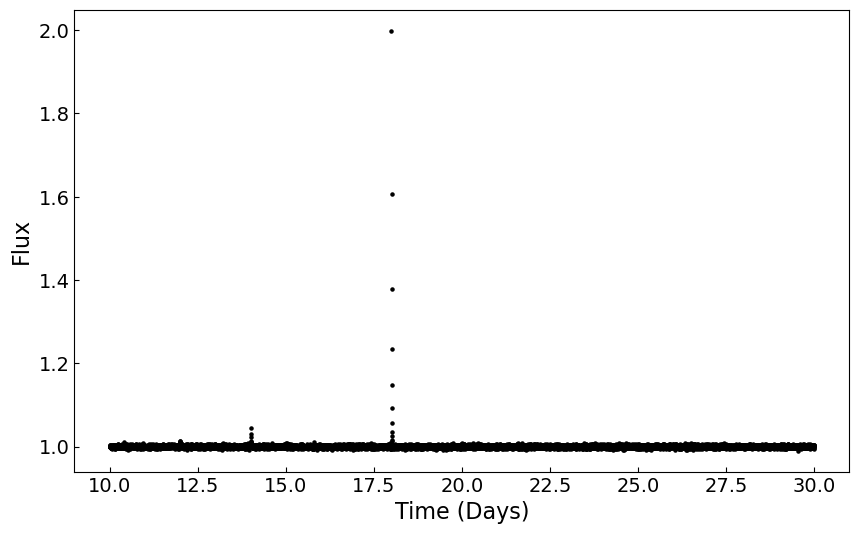

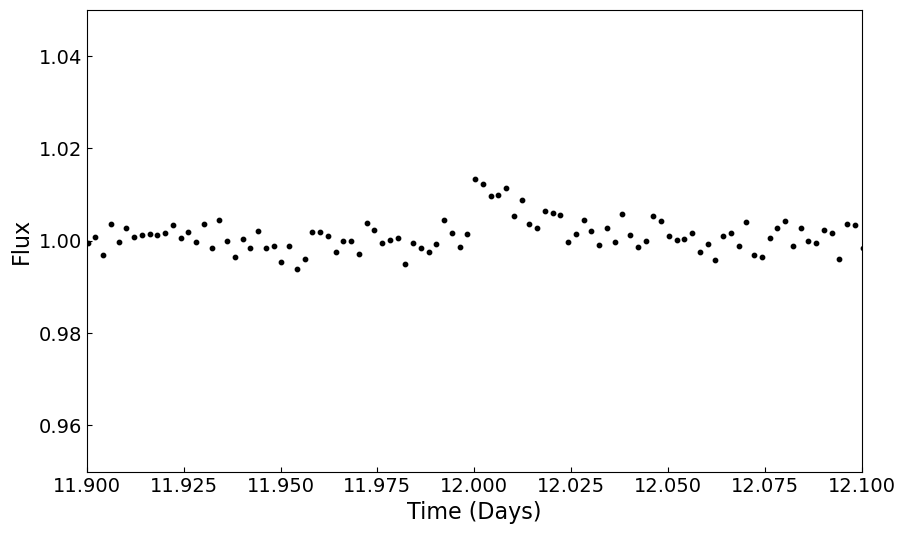

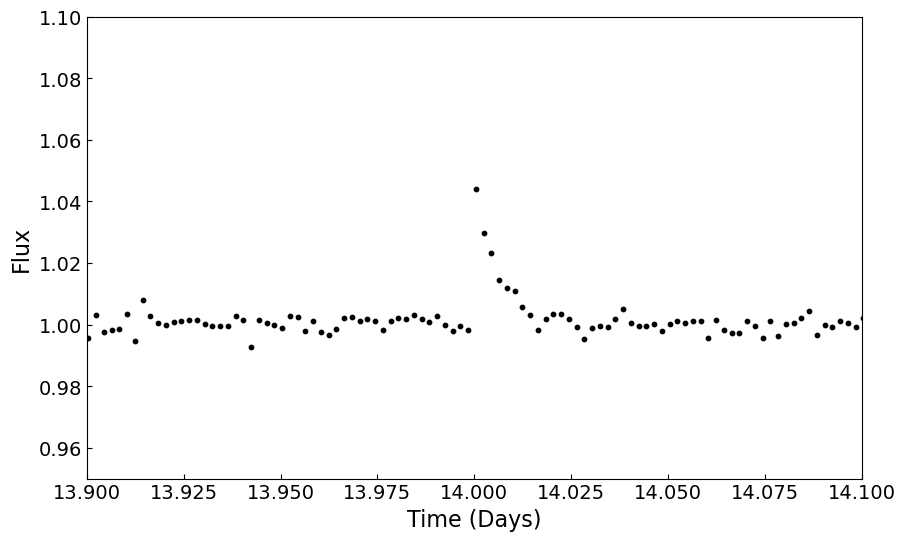

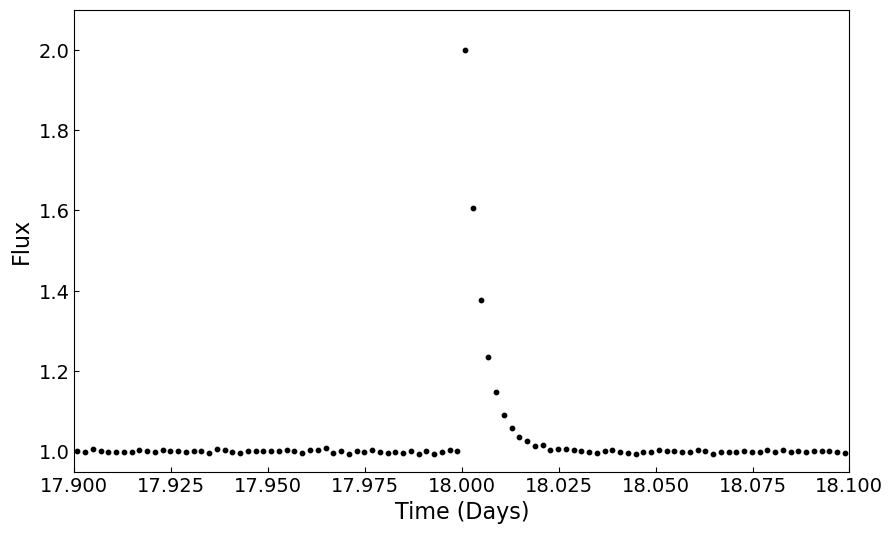

In [7]:
time, flux, flux_err, quality = generate_synth_lightcurve()

#plot
plt.figure(figsize = (10,6))
plt.scatter(time, flux, color = 'black', s = 5)
plt.xlabel('Time (Days)', fontsize = 16)
plt.ylabel('Flux', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()

#plot each flare
plt.figure(figsize = (10,6))
plt.scatter(time, flux, color = 'black', s = 10)
plt.xlim(11.9, 12.1)
plt.ylim(0.95, 1.05)
plt.xlabel('Time (Days)', fontsize = 16)
plt.ylabel('Flux', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()

#plot each flare
plt.figure(figsize = (10,6))
plt.scatter(time, flux, color = 'black', s = 10)
plt.xlim(13.9, 14.1)
plt.ylim(0.95, 1.1)
plt.xlabel('Time (Days)', fontsize = 16)
plt.ylabel('Flux', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()


#plot each flare
plt.figure(figsize = (10,6))
plt.scatter(time, flux, color = 'black', s = 10)
plt.xlim(17.9, 18.1)
plt.ylim(0.95, 2.1)
plt.xlabel('Time (Days)', fontsize = 16)
plt.ylabel('Flux', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()

Should look familiar. Let's look at how magic_flare_std affects detection. As intuition would suggest, increating magic_flare_std makes finding low amp flares harder and finding high amp flares easier. However we become more confident in the flares we do find as not being from noise.

We'll do this with the typicall method of searching for three or more consecutive points above a flux threshold. For this we need to make sure the consecutive argument is set to False

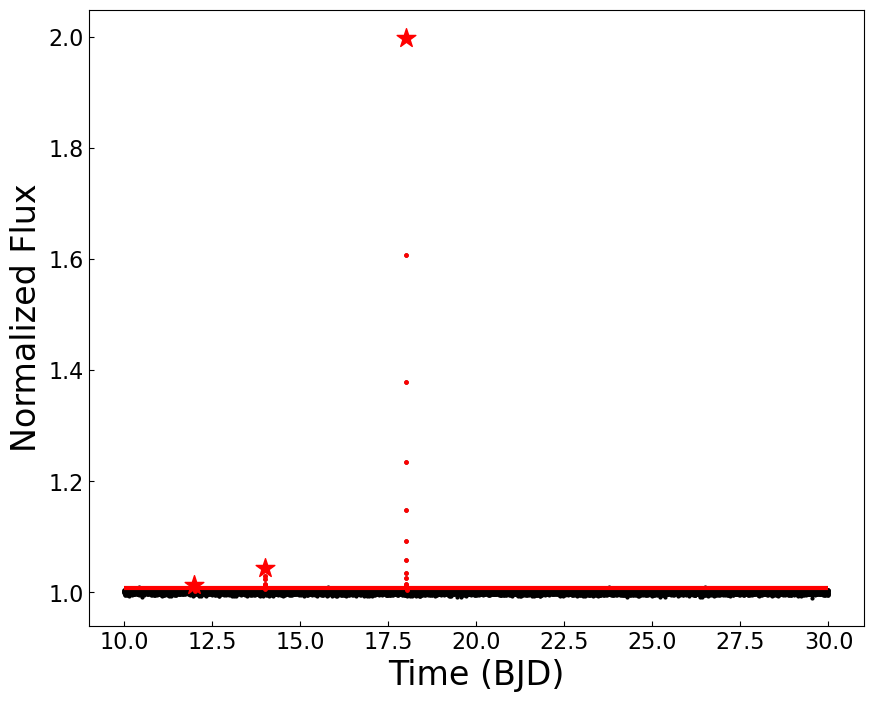

In [9]:
primary_color = 'red'

secondary_color = 'blue'

#Detrend

t_curve, quadratic, wotan_fit, flatt, periodic = toffee.flatten(time, flux, flux_err, plot_results=False,
                                              short_window=0.25, periodogram=[0.01, 10])

#sometimes the size of the arrays spat out by the flattening function is not the same as the light
#curve and thus not the same as the break_mask. So we need another mask to ensure they're the same

flattening_mask = np.full(len(time), 1, dtype = bool)

for index in range(len(time)):
    if time[index] in t_curve:
        continue
    else:
        flattening_mask[index] = False

#convert this mask to indices to include in the mask
flattening_mask = np.arange(len(time))[flattening_mask]

#find the breaks
sector_break_frame = toffee.break_finder(time, flux)
#Now color in the masked points in a different color
mask = toffee.light_curve_mask(time, flux, min_break = 0.01, clip_breaks = 100)
#apply flattening mask
mask = mask[flattening_mask]
#unpack flux after running periodogram and eliminating residual
#sinusoidal noise
flatt_trend = flatt[2]
flatt_flux = flatt[0]

###############Now is when we need to find the flares to plot them#############

flare_results = toffee.flare_finder(time, flux, flux_err, quality, detrend = False, consecutive = True)


primary_secondary = flare_color(flare_results)

times_of_primary_flares, fluxes_of_primary_flares, peak_flux_of_primary, peak_time_of_primary = (flare_color(flare_results)[0],
                                                                                                 flare_color(flare_results)[1],
                                                                                                 flare_color(flare_results)[2],
                                                                                                 flare_color(flare_results)[3])


times_of_secondary_flares, fluxes_of_secondary_flares, peak_flux_of_secondary, peak_time_of_secondary = (flare_color(flare_results)[4],
                                                                                                 flare_color(flare_results)[5],
                                                                                                 flare_color(flare_results)[6],
                                                                                                 flare_color(flare_results)[7])



#Third plot: Show the flattened lightcurve with the flares found and colored in
plt.figure(figsize = (10,8))
plt.scatter(time, flux, s = 4, color = 'black')
#color the points around the primary flares
plt.scatter(times_of_primary_flares, fluxes_of_primary_flares, color = primary_color, s = 6)
#color the points around the secondary flares
plt.scatter(times_of_secondary_flares, fluxes_of_secondary_flares, color = secondary_color, s = 6, zorder = 10)
#add primary flare peaks
plt.scatter(peak_time_of_primary, peak_flux_of_primary, marker = '*', s = 200, color = primary_color)       
#add secondary flare peaks
plt.scatter(peak_time_of_secondary, peak_flux_of_secondary, marker = '*', s = 200, color = secondary_color)
#add three sigma line
plt.hlines(3 * (np.nanpercentile(flux, 84) - 1) + 1, min(time), max(time), color = 'red', linewidth = 3)
plt.xlabel('Time (BJD)', fontsize = 24)
plt.ylabel(r'Normalized Flux', fontsize = 24)
#plt.ylim(0.9, 1.25)
plt.tick_params(direction = 'in', labelsize = 16)
plt.show()

Now raise magic_flare_std to a higher value

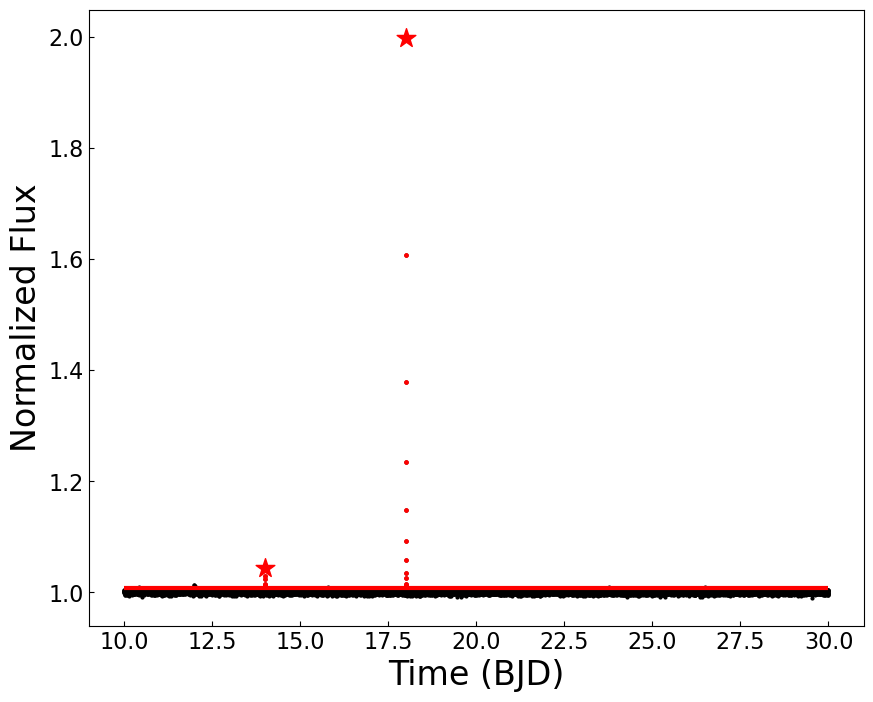

In [11]:

###############Now is when we need to find the flares to plot them#############
flare_results = toffee.flare_finder(time, flux, flux_err, quality,
                                    magic_flare_std = 5.0, detrend = False, consecutive = True)


primary_secondary = flare_color(flare_results)

times_of_primary_flares, fluxes_of_primary_flares, peak_flux_of_primary, peak_time_of_primary = (flare_color(flare_results)[0],
                                                                                                 flare_color(flare_results)[1],
                                                                                                 flare_color(flare_results)[2],
                                                                                                 flare_color(flare_results)[3])


times_of_secondary_flares, fluxes_of_secondary_flares, peak_flux_of_secondary, peak_time_of_secondary = (flare_color(flare_results)[4],
                                                                                                 flare_color(flare_results)[5],
                                                                                                 flare_color(flare_results)[6],
                                                                                                 flare_color(flare_results)[7])

#Third plot: Show the flattened lightcurve with the flares found and colored in
plt.figure(figsize = (10,8))
plt.scatter(time, flux, s = 4, color = 'black')
#color the points around the primary flares
plt.scatter(times_of_primary_flares, fluxes_of_primary_flares, color = primary_color, s = 6)
#color the points around the secondary flares
plt.scatter(times_of_secondary_flares, fluxes_of_secondary_flares, color = secondary_color, s = 6, zorder = 10)
#add primary flare peaks
plt.scatter(peak_time_of_primary, peak_flux_of_primary, marker = '*', s = 200, color = primary_color)       
#add secondary flare peaks
plt.scatter(peak_time_of_secondary, peak_flux_of_secondary, marker = '*', s = 200, color = secondary_color)
#add three sigma line
plt.hlines(3 * (np.nanpercentile(flux, 84) - 1) + 1, min(time), max(time), color = 'red', linewidth = 3)
plt.xlabel('Time (BJD)', fontsize = 24)
plt.ylabel(r'Normalized Flux', fontsize = 24)
#plt.ylim(0.9, 1.25)
plt.tick_params(direction = 'in', labelsize = 16)
plt.show()

If we raise the necessary threshold to be a 5σ reading we no longer detect the smallest flare at the beginning of the light curve, it's not bright enough. If we raise the threshold to 9.5σ we'll also no longer detect the intermediate flare and only find the largest flare.

The typical value adopted in the literature is 3σ but you can set it to whatever you think is best.

# Non-Consecutive Flare Detection

We'll now analyze how TOFFEE is able to detect flares that DONT have three consecutive points above a threshold

## Add Another Small Flare

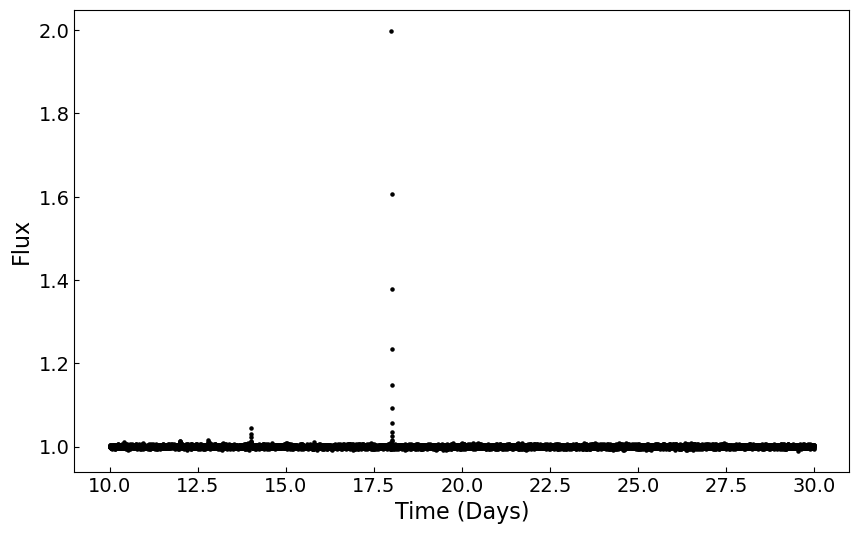

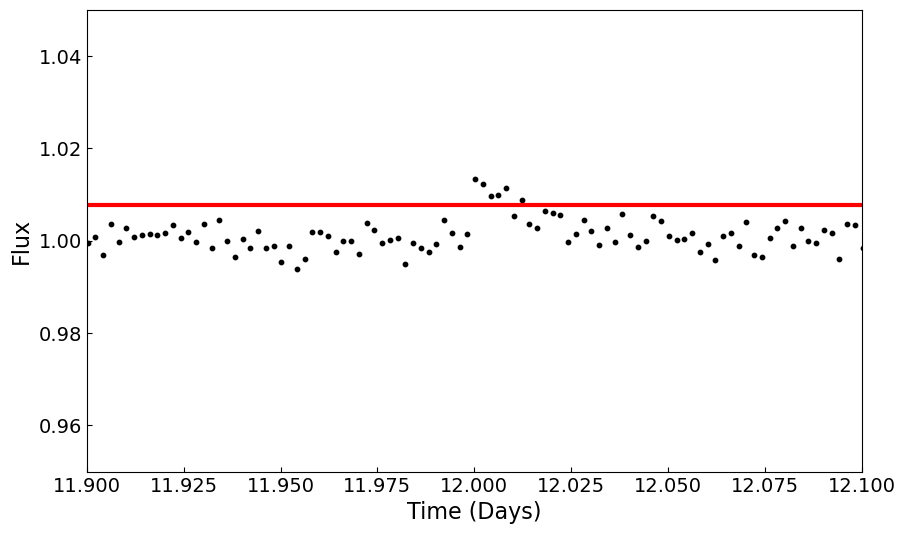

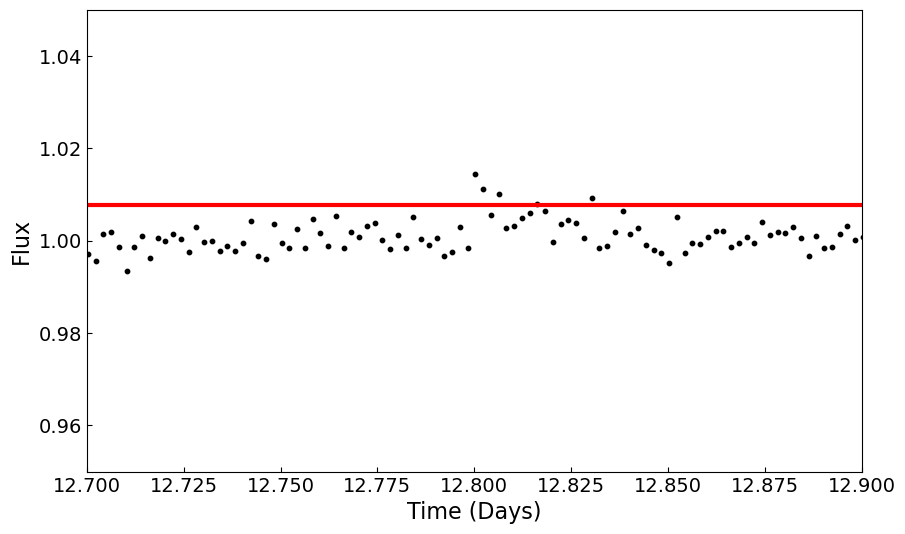

In [14]:
np.random.seed(42)
time, flux, flux_err, quality = generate_synth_lightcurve()


#Add another small flare
flux[1400:1420] = dbl_exp_decay(time[1400:1420], time[1400], 0.004, 50, 0.006, 60, 1) + np.random.normal(0, 2.5*10**-3, 20)
flux[1402] = flux[1402] - 0.004
flux[1403] = flux[1403] + 0.002
flux[1404] = flux[1404] - 0.002
flux[1405] = flux[1405] - 0.002

#plot
plt.figure(figsize = (10,6))
plt.scatter(time, flux, color = 'black', s = 5)
plt.xlabel('Time (Days)', fontsize = 16)
plt.ylabel('Flux', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()

#plot each flare
plt.figure(figsize = (10,6))
plt.scatter(time, flux, color = 'black', s = 10)
plt.hlines(3 * (np.nanpercentile(flux, 84) - 1) + 1, min(time), max(time), color = 'red', linewidth = 3)
plt.xlim(11.9, 12.1)
plt.ylim(0.95, 1.05)
plt.xlabel('Time (Days)', fontsize = 16)
plt.ylabel('Flux', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()

#plot each flare
plt.figure(figsize = (10,6))
plt.scatter(time, flux, color = 'black', s = 10)
plt.hlines(3 * (np.nanpercentile(flux, 84) - 1) + 1, min(time), max(time), color = 'red', linewidth = 3)
plt.xlim(12.7, 12.9)
plt.ylim(0.95, 1.05)
plt.xlabel('Time (Days)', fontsize = 16)
plt.ylabel('Flux', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()

We now see a slight difference with the small flares. While the first flare clearly has a set of three or more points that all lie above the flux threshold the second one doesn't. It has two above then one below then one above. We know it's a flare (albeit one I had to alter to specifically exhibit this behavior) so we may want to find these. In the literature this problem has been solved by stating one cadence below the threshold the separates two bright epochs does belong to the same epoch and can be identified as one flare.

However in practice with detrending lightcurves there is the chance for residual noise from the spot modulation that creates epochs that peek above and fluctuate above the threshold. The consecutive method is disastorous when theis happens as it may flag loads of regions of residual noise as flares closesly separated. The previously mentioned method may also not work as there can still be false positives

# Add Residual Red Noise

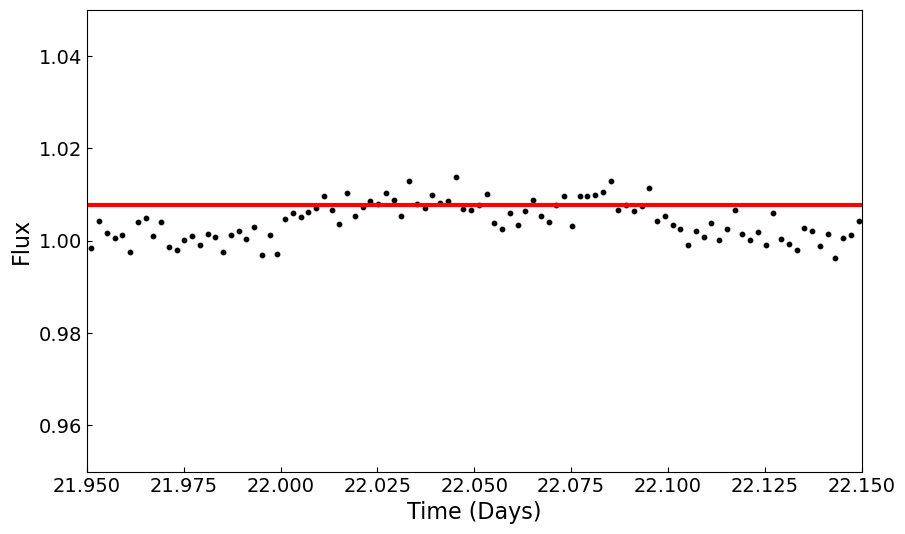

In [16]:
np.random.seed(42)
time, flux, flux_err, quality = generate_synth_lightcurve()

#Add another small flare
flux[1400:1420] = dbl_exp_decay(time[1400:1420], time[1400], 0.004, 50, 0.006, 60, 1) + np.random.normal(0, 2.5*10**-3, 20)
flux[1402] = flux[1402] - 0.004
flux[1403] = flux[1403] + 0.002
flux[1404] = flux[1404] - 0.002
flux[1405] = flux[1405] - 0.002

# Add a piece of the lightcurve indicative of residual noise or poor detrending
flux[6000:6050] = flux[6000:6050] + 0.0075

#plot each flare
plt.figure(figsize = (10,6))
plt.scatter(time, flux, color = 'black', s = 10)
plt.hlines(3 * (np.nanpercentile(flux, 84) - 1) + 1, min(time), max(time), color = 'red', linewidth = 3)
plt.xlim(21.95, 22.15)
plt.ylim(0.95, 1.05)
plt.xlabel('Time (Days)', fontsize = 16)
plt.ylabel('Flux', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()

This is a bit of a dramatized example, it's usually a bit more continous and sinusoidal but I'd say representative of what can pop up. Here we see both sets of three consecutive points above the threshold and points where there are three bright points separated by one cadence. It would help that there is a functionality in the threshold-based method to ignore these parts of the lightcurve even if they're bright.

## Run with Consecutive

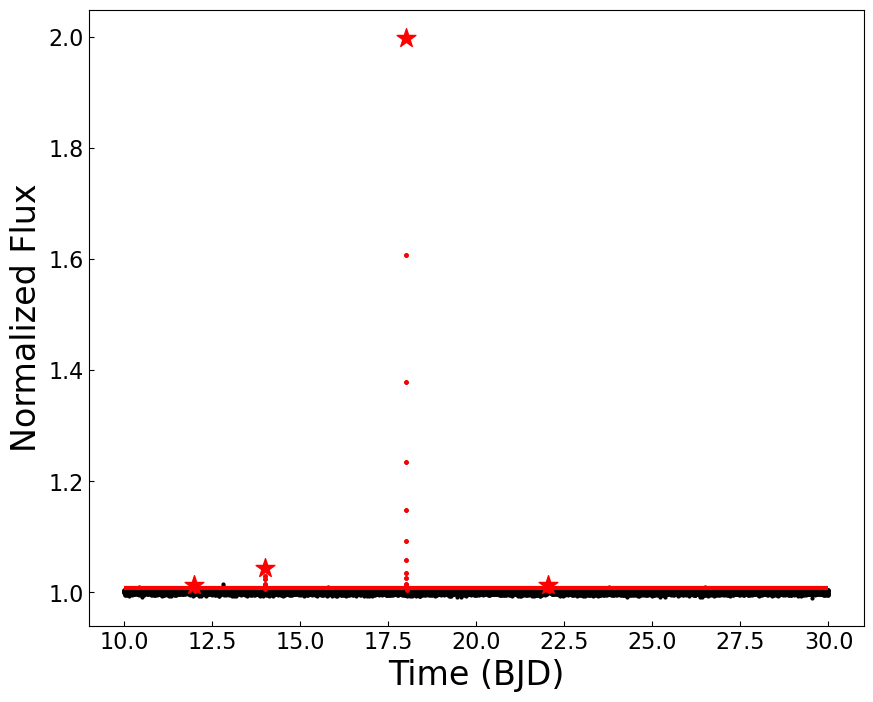

In [19]:

###############Now is when we need to find the flares to plot them#############
flare_results = toffee.flare_finder(time, flux, flux_err, quality,
                                    magic_flare_std = 3.0, detrend = False, consecutive = True)


primary_secondary = flare_color(flare_results)

times_of_primary_flares, fluxes_of_primary_flares, peak_flux_of_primary, peak_time_of_primary = (flare_color(flare_results)[0],
                                                                                                 flare_color(flare_results)[1],
                                                                                                 flare_color(flare_results)[2],
                                                                                                 flare_color(flare_results)[3])


times_of_secondary_flares, fluxes_of_secondary_flares, peak_flux_of_secondary, peak_time_of_secondary = (flare_color(flare_results)[4],
                                                                                                 flare_color(flare_results)[5],
                                                                                                 flare_color(flare_results)[6],
                                                                                                 flare_color(flare_results)[7])

#Third plot: Show the flattened lightcurve with the flares found and colored in
plt.figure(figsize = (10,8))
plt.scatter(time, flux, s = 4, color = 'black')
#color the points around the primary flares
plt.scatter(times_of_primary_flares, fluxes_of_primary_flares, color = primary_color, s = 6)
#color the points around the secondary flares
plt.scatter(times_of_secondary_flares, fluxes_of_secondary_flares, color = secondary_color, s = 6, zorder = 10)
#add primary flare peaks
plt.scatter(peak_time_of_primary, peak_flux_of_primary, marker = '*', s = 200, color = primary_color)       
#add secondary flare peaks
plt.scatter(peak_time_of_secondary, peak_flux_of_secondary, marker = '*', s = 200, color = secondary_color)
#add three sigma line
plt.hlines(3 * (np.nanpercentile(flux, 84) - 1) + 1, min(time), max(time), color = 'red', linewidth = 3)
plt.xlabel('Time (BJD)', fontsize = 24)
plt.ylabel(r'Normalized Flux', fontsize = 24)
#plt.ylim(0.9, 1.25)
plt.tick_params(direction = 'in', labelsize = 16)
plt.show()

As shown above, we miss the small flare we added at 12.8 days and picked up the residual noise as a flare at 22 days. Bummer

Now run it wil consecutive turned off.

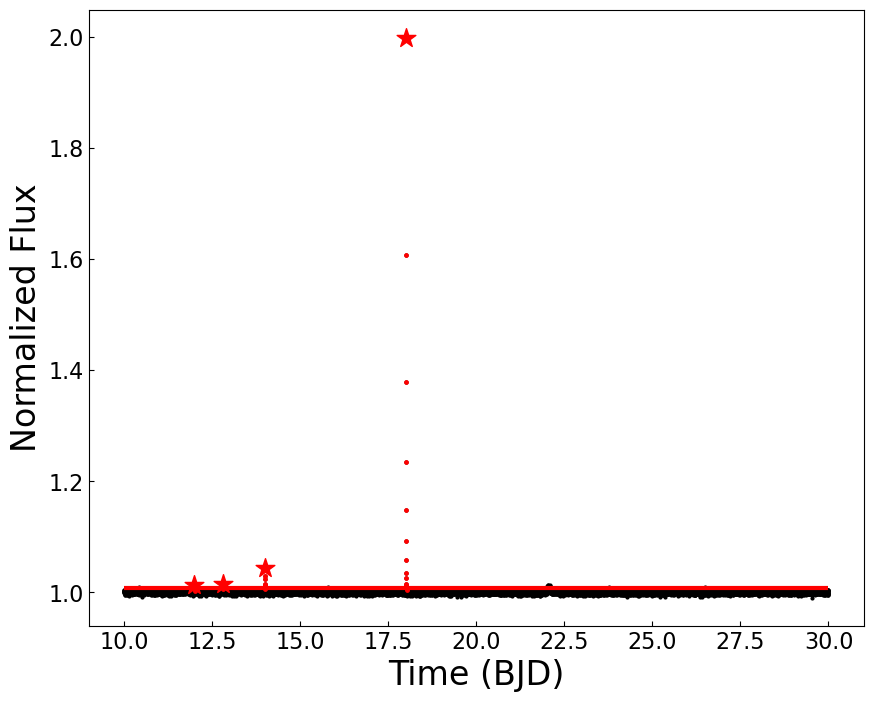

In [21]:

###############Now is when we need to find the flares to plot them#############
flare_results = toffee.flare_finder(time, flux, flux_err, quality,
                                    magic_flare_std = 3.0, detrend = False, consecutive = False, )


primary_secondary = flare_color(flare_results)

times_of_primary_flares, fluxes_of_primary_flares, peak_flux_of_primary, peak_time_of_primary = (flare_color(flare_results)[0],
                                                                                                 flare_color(flare_results)[1],
                                                                                                 flare_color(flare_results)[2],
                                                                                                 flare_color(flare_results)[3])


times_of_secondary_flares, fluxes_of_secondary_flares, peak_flux_of_secondary, peak_time_of_secondary = (flare_color(flare_results)[4],
                                                                                                 flare_color(flare_results)[5],
                                                                                                 flare_color(flare_results)[6],
                                                                                                 flare_color(flare_results)[7])

#Third plot: Show the flattened lightcurve with the flares found and colored in
plt.figure(figsize = (10,8))
plt.scatter(time, flux, s = 4, color = 'black')
#color the points around the primary flares
plt.scatter(times_of_primary_flares, fluxes_of_primary_flares, color = primary_color, s = 6)
#color the points around the secondary flares
plt.scatter(times_of_secondary_flares, fluxes_of_secondary_flares, color = secondary_color, s = 6, zorder = 10)
#add primary flare peaks
plt.scatter(peak_time_of_primary, peak_flux_of_primary, marker = '*', s = 200, color = primary_color)       
#add secondary flare peaks
plt.scatter(peak_time_of_secondary, peak_flux_of_secondary, marker = '*', s = 200, color = secondary_color)
#add three sigma line
plt.hlines(3 * (np.nanpercentile(flux, 84) - 1) + 1, min(time), max(time), color = 'red', linewidth = 3)
plt.xlabel('Time (BJD)', fontsize = 24)
plt.ylabel(r'Normalized Flux', fontsize = 24)
#plt.ylim(0.9, 1.25)
plt.tick_params(direction = 'in', labelsize = 16)
plt.show()

Now we pick up that low amp flare AND ignore the residual noise, nice!

Let's look under the hood and see how exactly this is working.

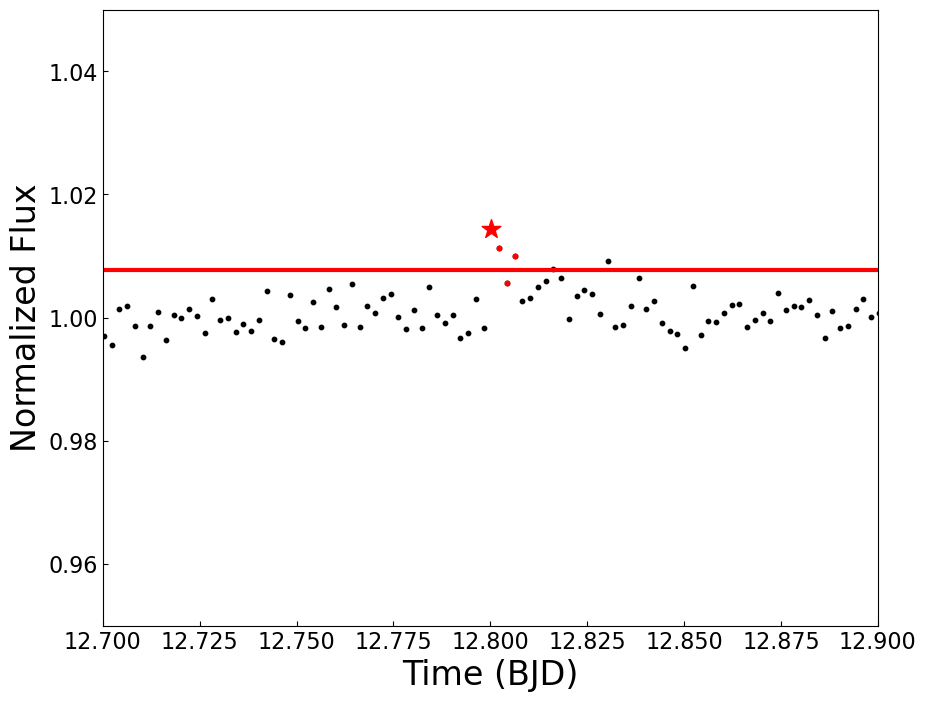

In [23]:
#Third plot: Show the flattened lightcurve with the flares found and colored in
plt.figure(figsize = (10,8))
plt.scatter(time, flux, s = 10, color = 'black')
#color the points around the primary flares
plt.scatter(times_of_primary_flares, fluxes_of_primary_flares, color = primary_color, s = 10)
#add primary flare peaks
plt.scatter(peak_time_of_primary, peak_flux_of_primary, marker = '*', s = 200, color = primary_color)       
#add three sigma line
plt.hlines(3 * (np.nanpercentile(flux, 84) - 1) + 1, min(time), max(time), color = 'red', linewidth = 3)
plt.xlabel('Time (BJD)', fontsize = 24)
plt.ylabel(r'Normalized Flux', fontsize = 24)
plt.xlim(12.7, 12.9)
plt.ylim(0.95, 1.05)
plt.tick_params(direction = 'in', labelsize = 16)
plt.show()

TOFFEE registered the point below the threshold along with the points above the threshold as belonging to the same flare. Too many points to the right are significantly below the flux threshold so they are no counted.

Under the nonconsecutive argument TOFFEE then takes these points and looks between the first point ABOVE the threshold and the last point ABOVE the threshold (what is refered to as the bright range in the code) and asks "Are there a signficant number of cadences between these two times above the flux threshold?" 

**Note**

The bright range is NOT necessarily the first and last point of the flare!)

What is considered "signficant is determined by the rate_above_threshold argument. If the ratio of the number of points above the threshold over the total number of points between first point ABOVE the threshold and the last point ABOVE the threshold is above that rate then it's included as a flare. It should be noted that the motive of this functionality was to catch flares like this where there are four cadences a part of the flare with one below the threshold, thus the "three in four rule." But you can change it to be stricter.

Let's look at that residual noise piece and see why it's being canceled out.

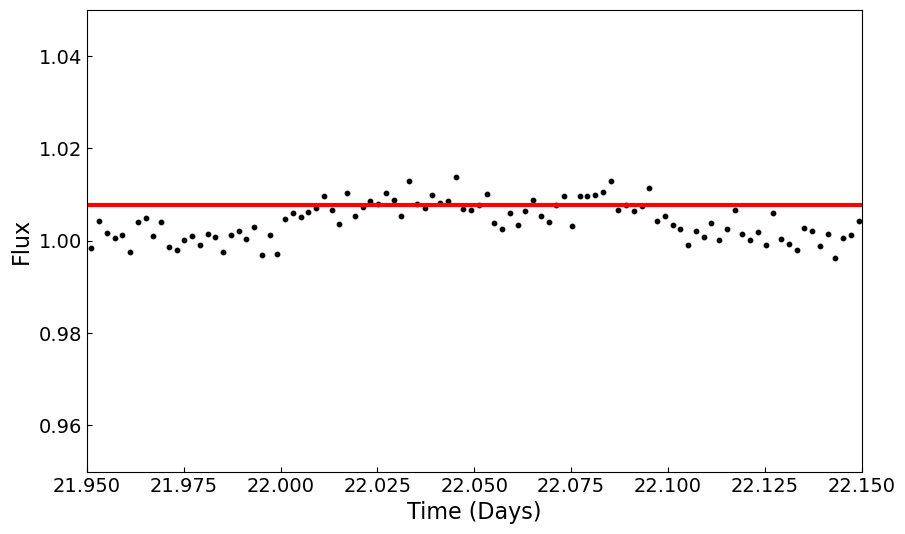

In [25]:
#plot each flare
plt.figure(figsize = (10,6))
plt.scatter(time, flux, color = 'black', s = 10)
plt.hlines(3 * (np.nanpercentile(flux, 84) - 1) + 1, min(time), max(time), color = 'red', linewidth = 3)
plt.xlim(21.95, 22.15)
plt.ylim(0.95, 1.05)
plt.xlabel('Time (Days)', fontsize = 16)
plt.ylabel('Flux', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()

We see the number of points between the first point above the threshold and the last is 43. Of those only 21 are above the threshold. Sure there are groups where three or more consecutive points are brighter but the rate is only 21/43 = 0.488, not a really confident signal. So it's ruled out as a possible flare.

One thing to note is that sometimes a flare occurs during one of these poorly detrended signals. Obviously it's a bit hard to parse these out with high confidence which is why detrending is the biggest limitation in quality flare detection in a threshold-based method. The way TOFFEE seeks to compromise high confidence reading with avoiding false-positives is that if there are three consecutive points above 1.5 * magic_flare_std (or 4.5σ for the usual 3σ threshold) it's counted as a flare anyways. At 4.5σ it's pretty likely that it's a flare and not residual noise.


Let's see the effect of raising rate_above_threshold to a value of 0.9

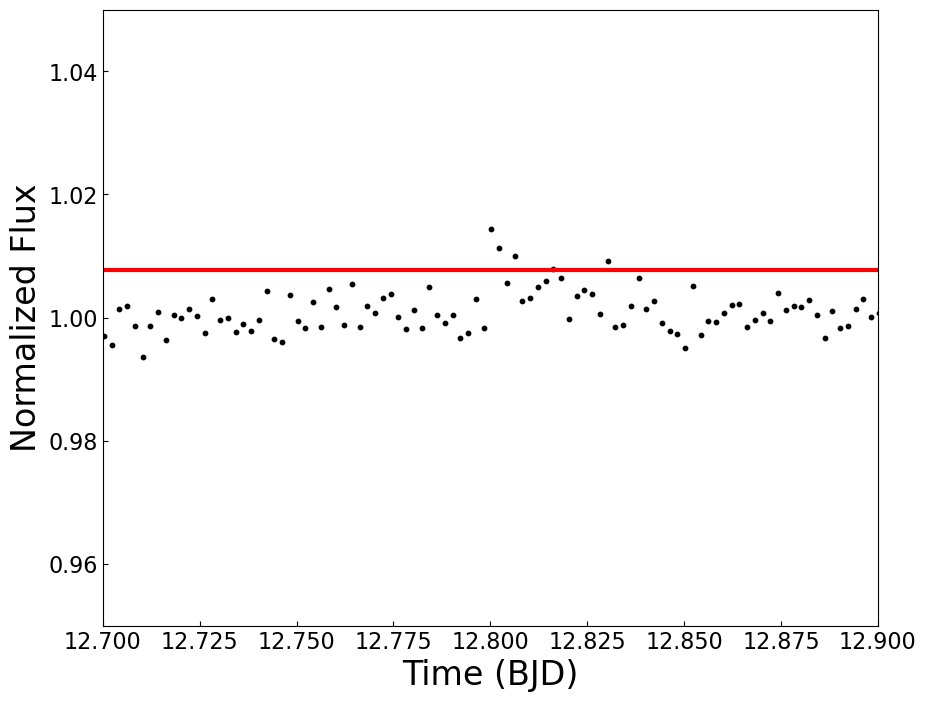

In [27]:
###############Now is when we need to find the flares to plot them#############
flare_results = toffee.flare_finder(time, flux, flux_err, quality,
                                    magic_flare_std = 3.0, detrend = False,
                                    consecutive = False, rate_above_threshold = 0.9, clip_breaks = None)


primary_secondary = flare_color(flare_results)

times_of_primary_flares, fluxes_of_primary_flares, peak_flux_of_primary, peak_time_of_primary = (flare_color(flare_results)[0],
                                                                                                 flare_color(flare_results)[1],
                                                                                                 flare_color(flare_results)[2],
                                                                                                 flare_color(flare_results)[3])


times_of_secondary_flares, fluxes_of_secondary_flares, peak_flux_of_secondary, peak_time_of_secondary = (flare_color(flare_results)[4],
                                                                                                 flare_color(flare_results)[5],
                                                                                                 flare_color(flare_results)[6],
                                                                                                 flare_color(flare_results)[7])

#Third plot: Show the flattened lightcurve with the flares found and colored in
plt.figure(figsize = (10,8))
plt.scatter(time, flux, s = 10, color = 'black')
#color the points around the primary flares
plt.scatter(times_of_primary_flares, fluxes_of_primary_flares, color = primary_color, s = 10)
#add primary flare peaks
plt.scatter(peak_time_of_primary, peak_flux_of_primary, marker = '*', s = 200, color = primary_color)       
#add three sigma line
plt.hlines(3 * (np.nanpercentile(flux, 84) - 1) + 1, min(time), max(time), color = 'red', linewidth = 3)
plt.xlabel('Time (BJD)', fontsize = 24)
plt.ylabel(r'Normalized Flux', fontsize = 24)
plt.xlim(12.7, 12.9)
plt.ylim(0.95, 1.05)
plt.tick_params(direction = 'in', labelsize = 16)
plt.show()

Now it's NOT registered as a flare! There are four points in the bright range with three above the threshold. That's a rate of 3/4 = 0.75 which is not greater than or equal to the required rate of 0.9. Feel free to toy with this for best results but it's advised not to go to a "three in five rule" or rate_above_threshold = 0.6 as it includes too many low quality signals.

# prim_marg_rate

This is left to the end because it's a relatively minor detail. It's not recommended to be altered but is left as a free parameter. It controls how many points to consider as a part of the flare that are below the flux threshold.

After TOFFEE recognizes a bright point corresponding to the peak flux of a flare it starts to look to the left and right trying to find the beginning and end of the flare. The way TOFFEE defines the beginning of a flare is the point in the lightcurve for which the next three points to the left are below a certain value of the flux. The same definition is used for the end of the flare but looking to the right of the point.

The value of that "certain value of the flux" is set by the prim_marg_rate argument. The sigma threshold that determines the beginning and end of the flare is given by magic_flare_std * prim_marg_rate. So for the default values of magic_flare_std = 3.0 and prim_marg_rate = 0.67 TOFFEE will consider a flare to have begun at a point where the next three points to the left are below 2σ and to have ended when the next three points to the right are below 2σ.

Let's return to the first, most basic lightcurve and look at the small flare

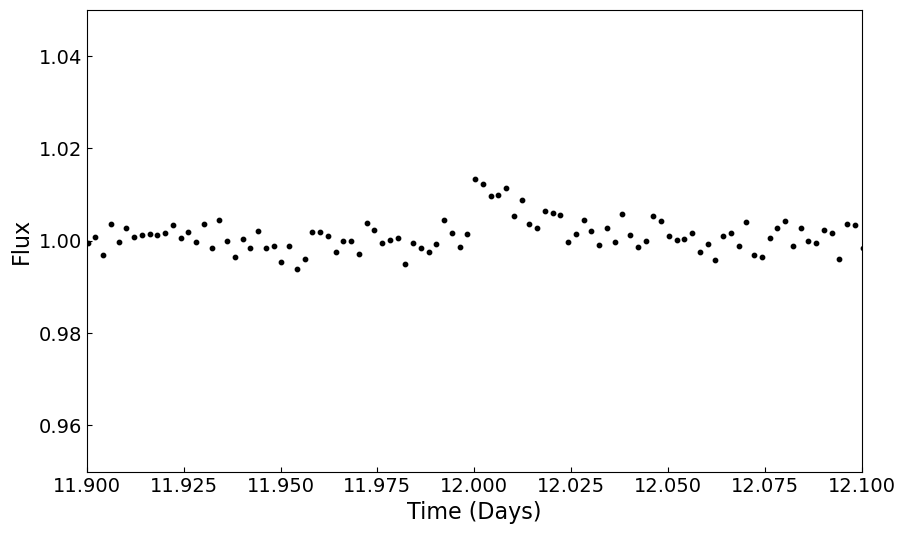

In [30]:
time, flux, flux_err, quality = generate_synth_lightcurve()

#plot the smallest flare
plt.figure(figsize = (10,6))
plt.scatter(time, flux, color = 'black', s = 10)
plt.xlim(11.9, 12.1)
plt.ylim(0.95, 1.05)
plt.xlabel('Time (Days)', fontsize = 16)
plt.ylabel('Flux', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()

Now let's toy with the values of prim_marg_rate

First let's set it to it's default value of 0.67

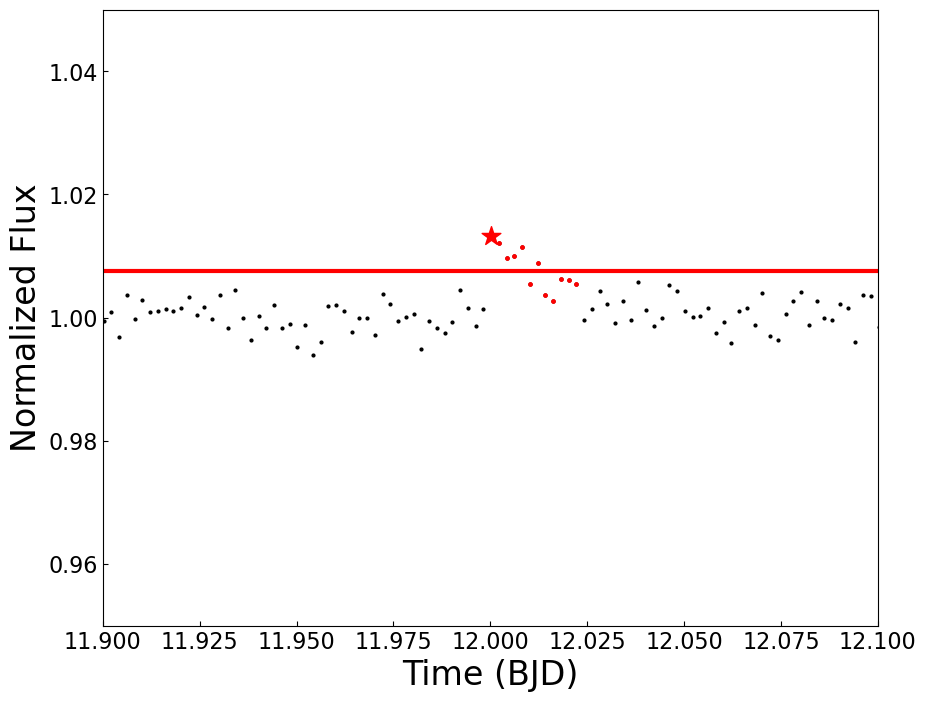

In [32]:

###############Now is when we need to find the flares to plot them#############
flare_results = toffee.flare_finder(time, flux, flux_err, quality, detrend = False, consecutive = False,
                                    prim_marg_rate = 0.67)


primary_secondary = flare_color(flare_results)

times_of_primary_flares, fluxes_of_primary_flares, peak_flux_of_primary, peak_time_of_primary = (flare_color(flare_results)[0],
                                                                                                 flare_color(flare_results)[1],
                                                                                                 flare_color(flare_results)[2],
                                                                                                 flare_color(flare_results)[3])


times_of_secondary_flares, fluxes_of_secondary_flares, peak_flux_of_secondary, peak_time_of_secondary = (flare_color(flare_results)[4],
                                                                                                 flare_color(flare_results)[5],
                                                                                                 flare_color(flare_results)[6],
                                                                                                 flare_color(flare_results)[7])

#Third plot: Show the flattened lightcurve with the flares found and colored in
plt.figure(figsize = (10,8))
plt.scatter(time, flux, s = 4, color = 'black')
#color the points around the primary flares
plt.scatter(times_of_primary_flares, fluxes_of_primary_flares, color = primary_color, s = 6)
#color the points around the secondary flares
plt.scatter(times_of_secondary_flares, fluxes_of_secondary_flares, color = secondary_color, s = 6, zorder = 10)
#add primary flare peaks
plt.scatter(peak_time_of_primary, peak_flux_of_primary, marker = '*', s = 200, color = primary_color)       
#add secondary flare peaks
plt.scatter(peak_time_of_secondary, peak_flux_of_secondary, marker = '*', s = 200, color = secondary_color)
#add three sigma line
plt.hlines(3 * (np.nanpercentile(flux, 84) - 1) + 1, min(time), max(time), color = 'red', linewidth = 3)
plt.xlabel('Time (BJD)', fontsize = 24)
plt.ylabel(r'Normalized Flux', fontsize = 24)
plt.xlim(11.9, 12.1)
plt.ylim(0.95, 1.05)
plt.tick_params(direction = 'in', labelsize = 16)
plt.show()

Now raise it to 0.9

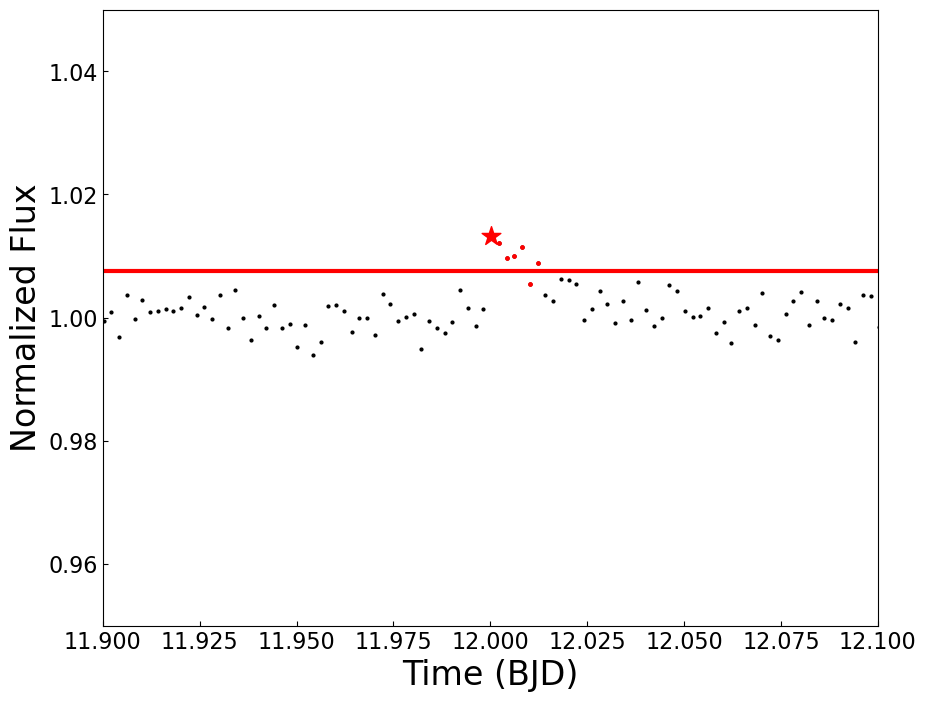

In [34]:
###############Now is when we need to find the flares to plot them#############
flare_results = toffee.flare_finder(time, flux, flux_err, quality, detrend = False, consecutive = False,
                                    prim_marg_rate = 0.9)


primary_secondary = flare_color(flare_results)

times_of_primary_flares, fluxes_of_primary_flares, peak_flux_of_primary, peak_time_of_primary = (flare_color(flare_results)[0],
                                                                                                 flare_color(flare_results)[1],
                                                                                                 flare_color(flare_results)[2],
                                                                                                 flare_color(flare_results)[3])


times_of_secondary_flares, fluxes_of_secondary_flares, peak_flux_of_secondary, peak_time_of_secondary = (flare_color(flare_results)[4],
                                                                                                 flare_color(flare_results)[5],
                                                                                                 flare_color(flare_results)[6],
                                                                                                 flare_color(flare_results)[7])

#Third plot: Show the flattened lightcurve with the flares found and colored in
plt.figure(figsize = (10,8))
plt.scatter(time, flux, s = 4, color = 'black')
#color the points around the primary flares
plt.scatter(times_of_primary_flares, fluxes_of_primary_flares, color = primary_color, s = 6)
#color the points around the secondary flares
plt.scatter(times_of_secondary_flares, fluxes_of_secondary_flares, color = secondary_color, s = 6, zorder = 10)
#add primary flare peaks
plt.scatter(peak_time_of_primary, peak_flux_of_primary, marker = '*', s = 200, color = primary_color)       
#add secondary flare peaks
plt.scatter(peak_time_of_secondary, peak_flux_of_secondary, marker = '*', s = 200, color = secondary_color)
#add three sigma line
plt.hlines(3 * (np.nanpercentile(flux, 84) - 1) + 1, min(time), max(time), color = 'red', linewidth = 3)
plt.xlabel('Time (BJD)', fontsize = 24)
plt.ylabel(r'Normalized Flux', fontsize = 24)
plt.xlim(11.9, 12.1)
plt.ylim(0.95, 1.05)
plt.tick_params(direction = 'in', labelsize = 16)
plt.show()

We see fewer red points meaning TOFFEE has recognized as being a part of the flare. This means it's much less likely that neighboring bright epochs are going to be lumped as one continous event, separating potential flares. It's not advised to make the value this high as you may get a bunch of extra fake flares in the tails of large flares as it fluctuates around the threshold and it'll be harder to tease out those detrending artifacts mentioned earlier. Setting it too low will make the duration of the flare unreasonably long and potentially lump two separate flare events into one. It's also unadvised because if it's too low the code will keep searching to the left and right for a long time looking for the end condition. In that search it may pick up a random cadence above the threshold. This will inflate the bright range and make the rate_above_threshold really small making a true flare signal get ignored because of a random point that isn't actually associated with a flare.

For an example of this we can return to the flare we used to illustrate the three in four rule

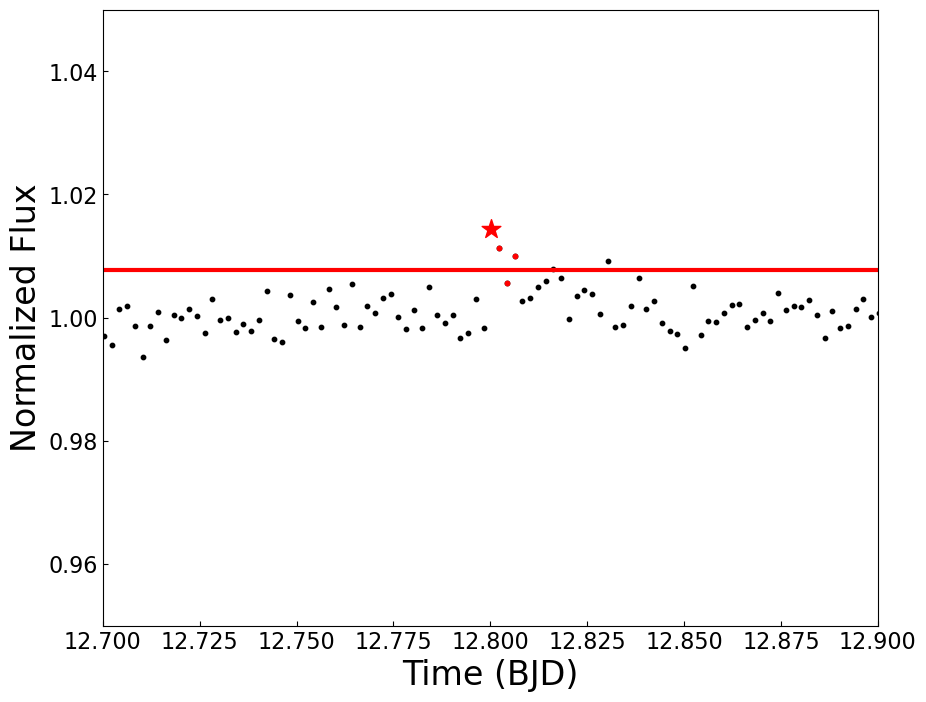

If we were to set the prim_marg_rate much lower the code would keep looking to the right for a series of points much lower than the threshold value. It would then pick up that one cadence that barely peeks above the threshold due to chance and set the bright range to be 9 with the number of bright point now 4 for a low rate_abv_threshold of 0.44. So sticking to 0.67 is a generally wise call. Although you may want to lower it if you raise the magic_flare_std.

So that's it! A couple knobs to dial in to your desires. Ultimately it depends on what KINDS of signals convince you that there's a flare in your lightcurve and how you want to balance completeness and precision.